## Frequentist Estimation of Limit/Interval

The following example show how to compute a frequentist limit. 

The limit is computed with a techinique called hypothesis test inversion.
An hypothesis test is performed for fixed values of the parameter of interest (e.g. $\mu$). 

The test is built with profile log-likelihood ratio as test statistics and using as $H_0$, the null hypothesis, the $S+B$ model vs $H_1$, the B$ only model. 

For each $\mu$ value, a p-value, which is the significance $\alpha$ of the test, is obtained and plotted as function of $\mu$. 

The interval at a given confidence level, CL = $1-\alpha_0$, is then obtained by looking at the values of $\mu$ which have a p-value equal to $\alpha_0$.

Different type of interval can be computed depending on the test statistics used. 

-  For upper limit the used test statistics is the one-side profiled likelihood :

$$q_\mu = - 2 \log \frac { L( x \ | \ \mu , \hat{\hat{\nu} } ) }{  L( x \ | \ \hat{\mu} , \hat{\nu}  ) } \  \  \ \mathrm{for} \  \  
\hat{\mu} \le \mu_{TEST}$$
$$q_\mu = 0     \hspace{3cm}     \ \mathrm{for} \  \  
\hat{\mu} \gt \mu_{TEST}$$

   The limit is then computed using the $CL_s$ procedure, i.e. the actual p-value used to build the scan curve is 
   $$CL_s = \frac{ CL_{S+B} } {CL_B } $$
   
- For Feldman-Cousins interval the two-sided profile likelihood is used:    

$$q_\mu = - 2 \log \frac { L( x \ | \ \mu , \hat{\hat{\nu} } ) }{  L( x \ | \ \hat{\mu} , \hat{\nu}  ) }$$

   for every obtained  $ \hat{\mu}$ value.
   
The code can also compute expected limits using the Asimov data set. 

At the beginning we compute the limit using the asympotic approximation of the distribution of the profile likelihood test statistics and we don't need to generate pseudo-experiments.  See paper *G. Cowan et al., arXiv:1007.1727,EPJC 71 (2011)* 

The asymptotic approximation is used only for computing $CL_s$ limits

Later we compute the full frequentist limit using pseudo-experiments and profiling nuisance parameter if are present. 


In [1]:
using namespace RooStats;

In [2]:
HypoTestInverter * calc = nullptr;
HypoTestInverterResult * result = nullptr; 
HypoTestInverterPlot * plot = nullptr; 
ProfileLikelihoodTestStat * testStat = nullptr; 
ToyMCSampler * toymcs = nullptr; 
SamplingDistPlot * distplot = nullptr;
TCanvas * c1 = nullptr; 
TCanvas * c2 = nullptr; 

#####  Reading the model (Workspace) from input file

First part is just to access the workspace file and retrieve the model and the data 

In [3]:
TString fileName = "CountingModelFixedB.root";
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  
// Use Minuit2 for minimization
ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");
// open the file 
auto file = TFile::Open(fileName);
// read workspace from the file 
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto sbModel = (RooStats::ModelConfig*) w->obj(modelConfigName);
sbModel->Print();
auto  data = w->data(dataName);
auto poi = (RooRealVar*) sbModel->GetParametersOfInterest()->first();


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


RooWorkspace(w) w contents

variables
---------
(b,nobs,s)

p.d.f.s
-------
RooPoisson::model[ x=nobs mean=nexp ] = 0.133853

functions
--------
RooAddition::nexp[ s + b ] = 6

datasets
--------
RooDataSet::data(nobs)

parameter snapshots
-------------------
ModelConfig__snapshot = (s=3)

named sets
----------
ModelConfig_Observables:(nobs)
ModelConfig_POI:(s)
ModelConfig__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::ModelConfig


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::model[ x=nobs mean=nexp ] = 0.133853
Snapshot:                
  1) 0x125a23c30 RooRealVar:: s = 3  L(0 - 15)  "s"



Print information about the number of events and background (works only in case of the specific counting model)

In [4]:
std::cout << "number of observed events in the data : " << std::endl;
auto args = data->get(0);
if (args) args->Print("V");
else  Error("BayesianNumerical","Input data does not contain any event");
std::cout << "number of background events " << w->var("b")->getVal() << std::endl;

number of observed events in the data : 
  1) RooRealVar:: nobs = 4
number of background events 3


##### Make the b Model by cloning the b model and use a value = 0 for the parameter of interest

In [5]:
sbModel->SetName("S+B Model");
auto bModel = (RooStats::ModelConfig*) sbModel->Clone("B Model");
poi->setVal(0);
bModel->SetSnapshot( *poi  );
sbModel->GetSnapshot()->Print("V");

  1) RooRealVar:: s = 3


###  Computation using Asymptotic formula

#### we create first the hypothesis test calculator: the `AsymptoticCalculator`
 
Note that in this case the NULL model is the S+B model. 

In [6]:
// RooStats::AsymptoticCalculator::SetPrintLevel(-1);  // to switch off print level 
RooStats::AsymptoticCalculator  asymCalc(*data, *bModel, *sbModel);

[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit2 / Migrad with strategy  1 and tolerance 1
Minuit2Minimizer: Minimize with max-calls 500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 1.63287648607349523
Edm   = 1.00184109331076172e-07
Nfcn  = 25
s	  = 1.0009	 +/-  1.90622	(limited)
AsymptoticCalculator::EvaluateNLL -  value = 1.63288	fit time : Real time 0:00:00, CP time 0.030
[#0] PROGRESS:Eval -- Best fitted POI value = 1.0009 +/- 1.90622
[#0] PROGRESS:Eval -- AsymptoticCalculator: Building Asimov data Set
[#1] INFO:InputArguments -- AsymptoticCalculator: Asimov data will be generated using fitted nuisance parameter values
MakeAsimov: Setting poi s to a constant value = 0
Generated Asimov data for observables RooArgSet:: = (nobs)
[#0] PROGRESS:Eval -- AsymptoticCalculator::

In [7]:
asymCalc.SetOneSided(true);  // for one-side test (compute a limit)
//asymCalc.SetPrintLevel(-1);  // to suppress print level 

####  Create the HypoTestInverter calculator and configure it 

In [8]:
calc = new RooStats::HypoTestInverter(asymCalc); 

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : S+B Model
		 using as B (alternate) model  : B Model



Configure the calculator

In [9]:
calc->SetConfidenceLevel(0.90);
calc->UseCLs(true); 
calc->SetVerbose(false);

calc->SetFixedScan(10,0.0,6.0); // set number of points , xmin and xmax 

asymCalc.SetOneSided(true);  // for one-side test (compute a limit)
asymCalc.SetPrintLevel(-1); 

#### Run now the calculator to compute the interval 

In [10]:
result = calc->GetInterval();

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:InputArguments -- Minimum of POI is 0 corresponds to alt  snapshot   - using qtilde asymptotic formulae  
[#1] INFO:Eval -- Using one-sided qmu - setting qmu to zero  muHat = 1.0009 muTest = 0
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:Eval -- Using one-sided qmu - setting qmu to zero  muHat = 1.0009 muTest = 0.666667
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) repl

In [11]:
cout << 100*calc->ConfidenceLevel() << "% interval is : ["<< result->LowerLimit() << ", "<< result->UpperLimit() <<"] "<<endl;

std::cout << "The computed upper limit is: " << result->UpperLimit() << std::endl;
  
  // compute expected limit
  std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
  std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
  std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
  std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
  std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
  std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

90% interval is : [0, 4.78386] 
The computed upper limit is: 4.78386
Expected upper limits, using the B (alternate) model : 
 expected limit (median) 3.84166
 expected limit (-1 sig) 2.49392
 expected limit (+1 sig) 6.15154
 expected limit (-2 sig) 1.76566
 expected limit (+2 sig) 8.41153


#### Plot now the result of the scan of the hypothesis tests

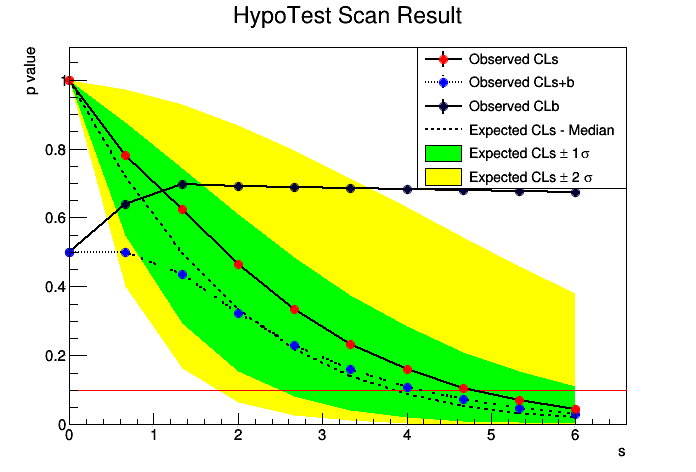

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [12]:
plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
gPad->Draw();

### Frequentist Calculator

We run now on the same model the FrequentistCalculator. The Frequentist Calculator uses the test statistic distributions obtained with pseudo-experiments.

#### Set the type of limit: CLs or FC ? 

In [13]:
bool useCLs = false; 

In [14]:
RooStats::FrequentistCalculator   fc(*data, *bModel, *sbModel);

We need also to specify the test statistics type. Here are some possible test statistics to use 

In [15]:
testStat = new RooStats::ProfileLikelihoodTestStat(*sbModel->GetPdf());

In [16]:
toymcs = (RooStats::ToyMCSampler*)fc.GetTestStatSampler();
toymcs->SetTestStatistic(testStat);

In [17]:
// for number counting experiments (i.e. when we have only one event per toy)
// in general shape cases are extended model
if (!sbModel->GetPdf()->canBeExtended())
    toymcs->SetNEventsPerToy(1);

We create and configure the RooStats calculators to compute the frequentist interval using the inversion of the hypothesis test

In [18]:
calc = new RooStats::HypoTestInverter(fc);

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : S+B Model
		 using as B (alternate) model  : B Model



#### Configure the Calculator

We can configure the calculator to compute CLs limits or Feldman-Cousins intervals.
These first lines are for CLs limits.

In [19]:
// for CLS
if (useCLs) {
    calc->UseCLs(true);
    testStat->SetOneSided(true);
}

These are for Feldman-Cousins intervals. Uncomment the lines if you want to compute them 

In [20]:
// uncomment these lines for Feldman Cousins intervals
if (!useCLs) {
  calc->Clear();
  calc->UseCLs(false);
  testStat->SetOneSided(false);
}

We configure the Frequentist calculator by specifying the number of toys for the two hypothesis 

In [21]:
fc.SetToys(1000,1000);    // 1000 for null (S+B) and 500 for alt (B) 

#### Run the toys to compute the test statistic distributions

Run now the calculator. We configure also the CL level and the range and number of points to scan. 
It can take some time... be patient 

In [22]:
calc->Clear(); // needed if running a second time
calc->SetConfidenceLevel(0.90);  
calc->SetFixedScan(10,0.1,5.1); // set number of points , xmin and xmax 
result = calc->GetInterval();

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot

=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::model[ x=nobs mean=nexp ] = 0.223677
Snapshot:                
  1) 0x125c5b220 RooRealVar:: s = 0.1  L(0 - 15)  "s"


=== Using the following for B Model ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::model[ x=nobs mean=nexp ] = 0.223677
Snapshot:                
  1) 0x125c5b220 RooRealVar:: s = 0  L(0 - 15)  "s"

[#0] PROGRESS:Generation -- Test Statistic on data: 0.119568
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now co

#### Examine the result

We examine now the result of the calculator. 
From the scan we can also compute in addition to the observed interval limits, also the expected values (median and +/- 1,2 sigma), which are computed using the same pseudo-experiments used to compute the observed limits. 

In [23]:
cout << 100*calc->ConfidenceLevel() << "% interval is : ["<< result->LowerLimit() << ", "<< result->UpperLimit() <<"] "<<endl;

std::cout << "The computed upper limit is: " << result->UpperLimit() << std::endl;
  
  // compute expected limit
  std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
  std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
  std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
  std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
  std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
  std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

90% interval is : [[#0] WARNING:Eval -- HypoTestInverterResult::CalculateEstimatedError - no valid points - cannot estimate  the lower limit error 
0, 5.29536] 
The computed upper limit is: 5.29536
Expected upper limits, using the B (alternate) model : 
 expected limit (median) 4.33976
 expected limit (-1 sig) 1.84004
 expected limit (+1 sig) 5.29536
 expected limit (-2 sig) 0.655556
 expected limit (+2 sig) 7.35624


#### Plot Result of Scan

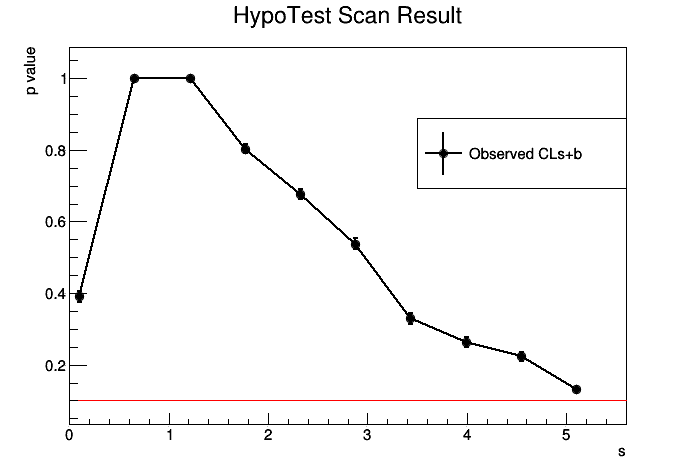

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [24]:
c1 = new TCanvas("c1","HypoTest Scan Result");
plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
if (useCLs) 
 plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
else 
 plot->Draw("OBS");  // draw only the observed value   
     
c1->SetLogy(0);
c1->Draw();

#### Plot Result of Test Statistic Distribution

Plot now the test statistics distributions for some of the scanned points

In [25]:
//%jsroot on

In [ ]:
c2 = new TCanvas("c2","Test Statistic Distributions",1000,800);
c2->Divide(2,2);
for (int i = 1; i/2 < 5 && i < result->ArraySize(); i+=2){
    c2->cd(i/2+1);
    distplot = plot->MakeTestStatPlot(i);
    distplot->SetLogYaxis(true);
    distplot->Draw();
    text = new TText(.6,.6,TString::Format("%s = %f",poi->GetName(),result->GetXValue(i)));
    text->SetNDC();
    text->Draw();    
}
c2->Draw();